In [1]:
import os
#os.chdir(os.path.abspath(os.path.join(__file__, os.pardir)))
#os.chdir(os.path.dirname(os.path.realpath(__file__)))
print(os.getcwd())
from __future__ import print_function
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; } .output_svg > div { width: 100% !important; height: 100% !important; }</style>"))
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.mpl_style = 'default'
import corpus, preprocessing, visualize

/mnt/DATA/DEVELOPING/PycharmProjects/recursive-dependency-embedding


/home/arne/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
import fnmatch, ntpath
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/sick/process_sentence3/SICK_CMaggregate'
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/ppdb/process_sentence3_ns1/PPDB_CMaggregate'
#train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/sick/process_sentence3/SICK_tt_CMaggregate'
train_data_path = '/media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence3/HASAN_CMaggregate'
parent_dir = os.path.abspath(os.path.join(train_data_path, os.pardir))
train_fnames = fnmatch.filter(os.listdir(parent_dir), ntpath.basename(train_data_path) + '.train.*')
train_fnames = [os.path.join(parent_dir, fn) for fn in train_fnames]
train_fnames

['/media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence3/HASAN_CMaggregate.train.0',
 '/media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence3/HASAN_CMaggregate.train.1',
 '/media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence3/HASAN_CMaggregate.train.2',
 '/media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence3/HASAN_CMaggregate.train.3',
 '/media/arne/WIN/Users/Arne/ML/data/corpora/debate_cluster/process_sentence3/HASAN_CMaggregate.train.4']

In [3]:
import corpus
types = corpus.read_types(train_data_path)

In [4]:
import train_fold, similarity_tree_tuple_pb2

def data_iterator(filenames):
    return train_fold.iterate_over_tf_record_protos(
    filenames, similarity_tree_tuple_pb2.SimilarityTreeTuple, multiple_epochs=False)

In [5]:
from itertools import izip
def get_sentence_from_dep_sequence_node(dep_sequence_node):
    arrays = preprocessing.sequence_node_to_arrays(dep_sequence_node)
    texts = visualize.get_text(arrays, types)
    texts_pair = list(izip(*[iter(texts)]*2))
    return [b for (a,b) in texts_pair]

def get_child_ids_from_dep_sequence_node(dep_sequence_node):
    return [child['head'] for child in dep_sequence_node['children']]

In [6]:
#train_iterator = data_iterator(train_fnames[:-1])
train_iterator = data_iterator(train_fnames[:-1])
test_iterator = data_iterator([train_fnames[-1]])

print('load test data ...')
#tuples_test = list(test_iterator)
#print('convert test data ...')
tuples_tokenids_test = [(get_child_ids_from_dep_sequence_node(similarity_tree_tuple['first']), get_child_ids_from_dep_sequence_node(similarity_tree_tuple['second']), similarity_tree_tuple['similarity']) for similarity_tree_tuple in test_iterator]
print(str(len(tuples_tokenids_test)))
print('load train data ...')
#tuples_train = list(train_iterator)
#print('convert train data ...')
tuples_tokenids_train = [(get_child_ids_from_dep_sequence_node(similarity_tree_tuple['first']), get_child_ids_from_dep_sequence_node(similarity_tree_tuple['second']), similarity_tree_tuple['similarity']) for similarity_tree_tuple in train_iterator]
print(str(len(tuples_tokenids_train)))

load test data ...
44988
load train data ...
179952


In [7]:
def ids_to_text(ids):
    return ' '.join([types[i] for i in ids])

print('convert train ids ...')
texts_train = [(ids_to_text(ids1), ids_to_text(ids2), sim) for ids1, ids2, sim in tuples_tokenids_train]
print('convert test ids ...')
texts_test = [(ids_to_text(ids1), ids_to_text(ids2), sim) for ids1, ids2, sim in tuples_tokenids_test]

convert train ids ...
convert test ids ...


In [8]:
len_train = [len(ids1) + len(ids2) for ids1, ids2, sim in tuples_tokenids_train]
len_test = [len(ids1) + len(ids2) for ids1, ids2, sim in tuples_tokenids_test]

/home/arne/miniconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


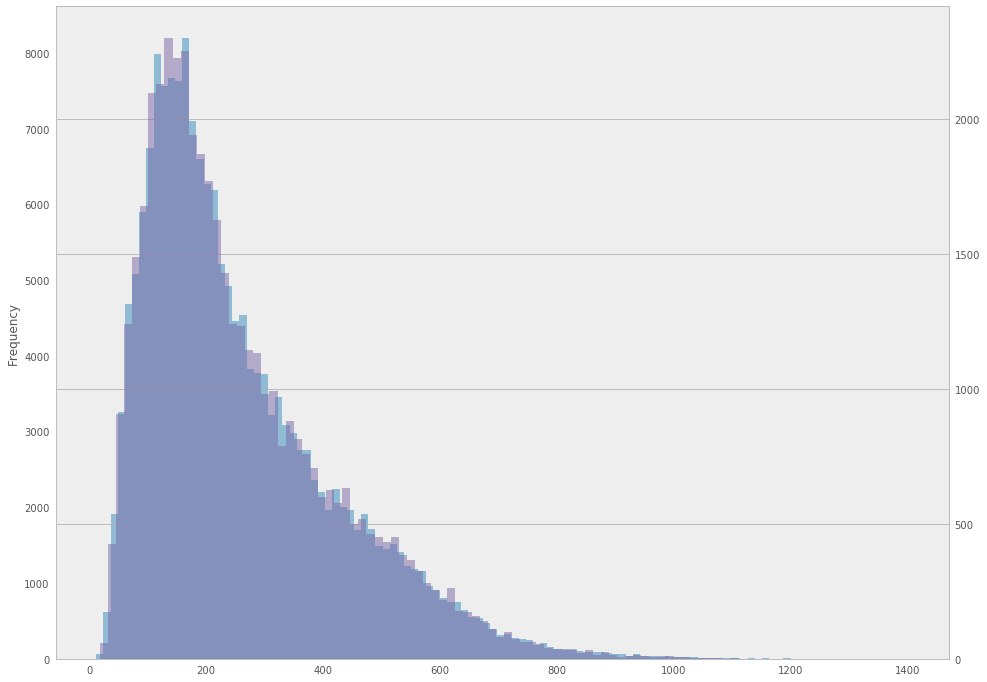

In [9]:
#df_len = pd.DataFrame({'train': pd.Series(len_train), 'test': pd.Series(len_test)})
#df_len.hist(bins=100, figsize=(32, 12))
#f = plt.figure()
s_len_train = pd.Series(len_train)
s_len_test = pd.Series(len_test)
s_len_train.plot(kind='hist', bins=100, figsize=(16, 12), label='train', alpha=0.5)
s_len_test.plot(kind='hist', bins=100, figsize=(16, 12), label='test', alpha=0.5, secondary_y=True)

In [10]:
s_len_train.describe()

count    179952.000000
mean        259.679126
std         165.722424
min          12.000000
25%         136.000000
50%         213.000000
75%         347.000000
max        1236.000000
dtype: float64

In [11]:
s_len_test.describe()

count    44988.000000
mean       259.126767
std        164.503015
min         18.000000
25%        136.000000
50%        212.500000
75%        348.000000
max       1400.000000
dtype: float64

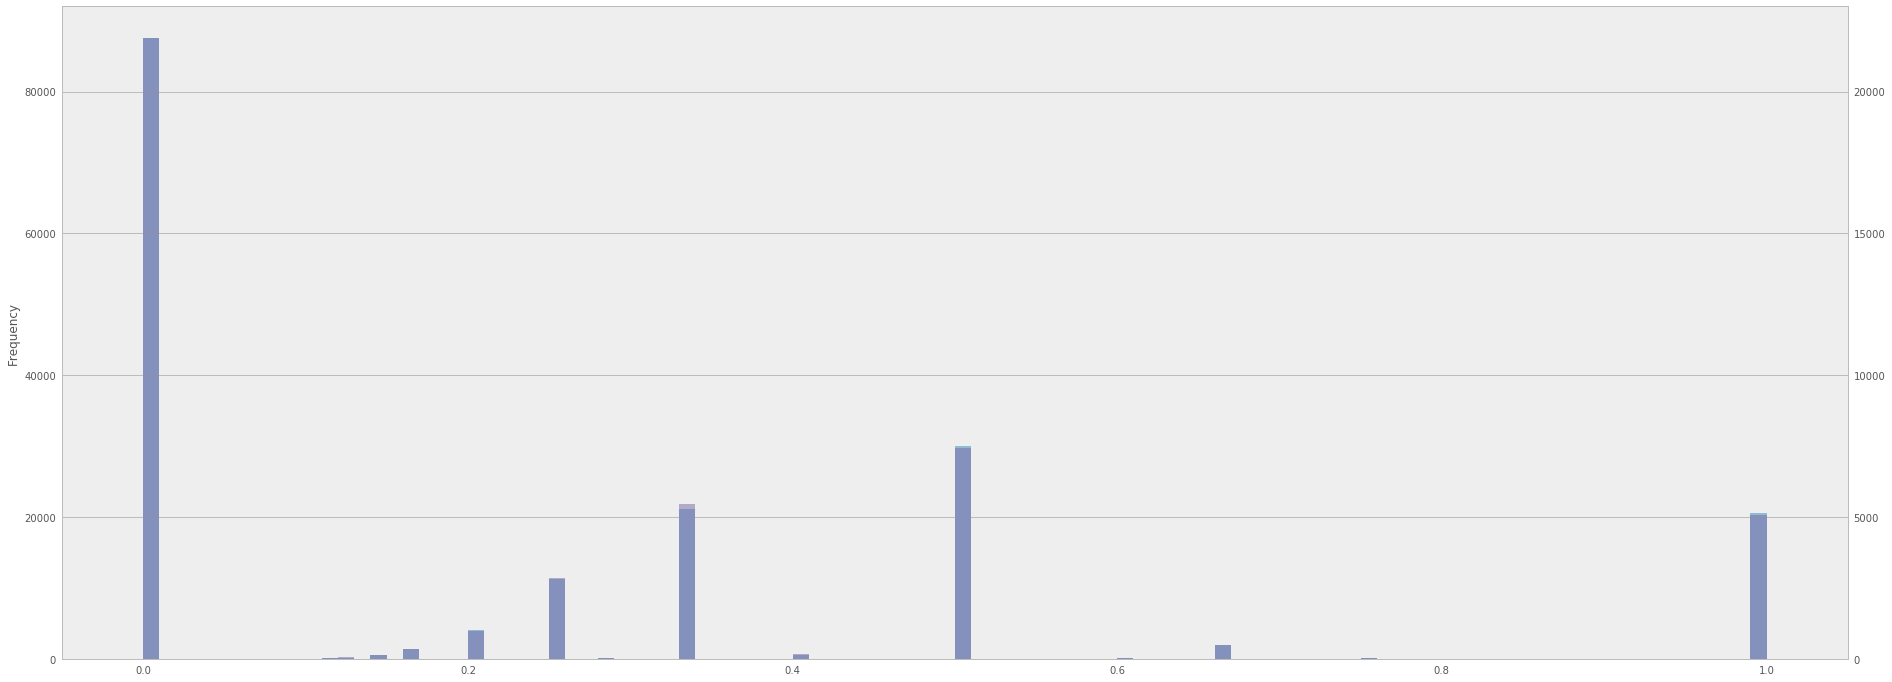

In [12]:
s_sims_train = pd.Series([sim for (_, _, sim) in tuples_tokenids_train])
s_sims_test = pd.Series([sim for (_, _, sim) in tuples_tokenids_test])

s_sims_train.plot(kind='hist',bins=100, figsize=(32, 12), alpha=0.5)
s_sims_test.plot(kind='hist',bins=100, figsize=(32, 12), alpha=0.5, secondary_y=True)

#df_sim = pd.DataFrame({'train': s_sims_train, 'test': s_sims_test})
#df_sim.plot(kind='hist',bins=100, figsize=(16, 12))
#df_sim.hist(bins=100, figsize=(32, 12))

In [13]:
s_sims_train.describe()

count    191532.000000
mean          0.266356
std           0.325929
min           0.000000
25%           0.000000
50%           0.200000
75%           0.500000
max           1.000000
dtype: float64

In [14]:
s_sims_test.describe()

count    47883.000000
mean         0.266069
std          0.326349
min          0.000000
25%          0.000000
50%          0.166667
75%          0.500000
max          1.000000
dtype: float64

In [ ]:
def print_stats(texts_train, texts_test):
    train_sentences_first_unique = set([s1 for (s1, s2, sc) in texts_train])
    train_sentences_second_unique = set([s2 for (s1, s2, sc) in texts_train])
    print('train_sentences_first_unique:\t'+str(len(train_sentences_first_unique)))
    print('train_sentences_second_unique:\t'+str(len(train_sentences_second_unique)))
    train_sentences_unique = train_sentences_first_unique
    train_sentences_unique.update(train_sentences_second_unique)
    print('train_sentences_unique:\t'+str(len(train_sentences_unique)))

    train_tuple = [s1+s2 for (s1, s2, sc) in texts_train]
    print('train_tuple duplicates: '+ str(len(train_tuple) - len(set(train_tuple))))
    print('train_tuple unique: '+ str(len(set(train_tuple))))

    test_sentences_first_unique = set([s1 for (s1, s2, sc) in texts_test])
    test_sentences_second_unique = set([s2 for (s1, s2, sc) in texts_test])
    print('test_sentences_first_unique:\t'+str(len(test_sentences_first_unique)))
    print('test_sentences_second_unique:\t'+str(len(test_sentences_second_unique)))
    test_sentences_unique = test_sentences_first_unique
    test_sentences_unique.update(test_sentences_second_unique)
    print('test_sentences_unique:\t'+str(len(test_sentences_unique)))

    test_tuple = [s1+s2 for (s1, s2, sc) in texts_test]
    print('test_tuple duplicates: '+ str(len(test_tuple) - len(set(test_tuple))))
    print('test_tuple unique: '+ str(len(set(test_tuple))))

    sentences_unique = train_sentences_unique
    sentences_unique.update(test_sentences_unique)
    print('sentences_unique:\t'+str(len(sentences_unique)))
    
    tuple_unique = set(train_tuple)
    tuple_unique.update(set(test_tuple))
    print('tuple unique: '+ str(len(tuple_unique)))
    print('train/test tuple overlap: '+ str(len(set(train_tuple)) + len(set(test_tuple)) - len(tuple_unique)))